In [260]:
import pickle as pkl
import numpy as np

X = pkl.load(open('./data/X_processed.pkl', 'rb'))
y = pkl.load(open('./data/y_processed.pkl', 'rb'))

print(X.shape, y.shape)

((6502, 3, 12), (6502,))


In [262]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

training_size = 6000

X_train = X[:training_size]
y_train = y[:training_size]

X_test = X[training_size:]
y_test = y[training_size:]

X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.9322709163346613

(array([ 40,  67, 128, 172, 233, 288, 383, 440, 475, 556, 561]),)


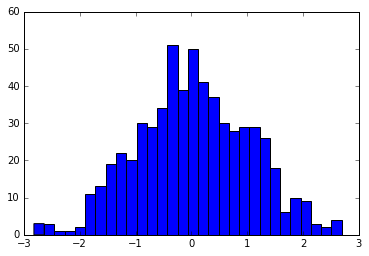

In [263]:
noise = np.random.normal(0, 1, 600)
plt.hist(noise, bins=30)
print(np.where(abs(noise)<0.01))

In [312]:
#directory = './output/2.0_0.001_200_0.002_100/'
directory = './output/1.0_0.001_200_0.0002_100/'

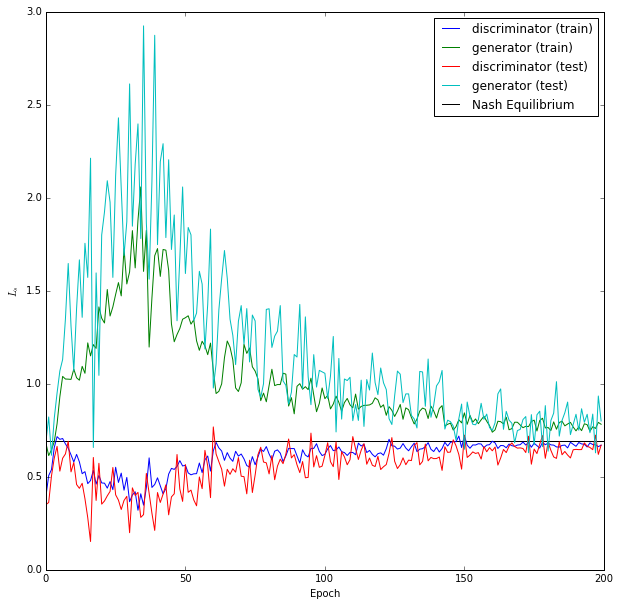

In [313]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.figure(figsize=(10,10))

hist = pkl.load(open(directory + '/acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')

plt.show()

# for p in hist['privacy']:
#     print(p)

In [314]:
print(hist['privacy'][-1])

[EpsDelta(spent_eps=0.125, spent_delta=0.9704068529561307), EpsDelta(spent_eps=0.25, spent_delta=0.8167355827120689), EpsDelta(spent_eps=0.5, spent_delta=0.4090508590127158), EpsDelta(spent_eps=1, spent_delta=0.04056649585327955), EpsDelta(spent_eps=2, spent_delta=0.00011143111855882808), EpsDelta(spent_eps=4, spent_delta=5.775556401168533e-10), EpsDelta(spent_eps=8, spent_delta=3.993450779787888e-22)]


# Transfer Learning

In [303]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

acgan = __import__('ac_gan')

from glob import glob
from keras.models import load_model

latent_size = 100

# for i in range(15, 30):
for i in range(125, 145):
    gen_name = sorted(glob(directory + 'params_generator*'))[-i]
    print(gen_name)
    g = load_model(gen_name)

    generate_count = training_size

    noise = np.random.uniform(-1, 1, (generate_count, latent_size))
    sampled_labels = np.random.randint(0, 2, generate_count)
    generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

#     print(generated_images.shape)
    gen_X_train = np.reshape(generated_images, (training_size, 3, 12))

#     print(np.max(gen_X_train))
#     print(np.min(gen_X_train))

    for i in range(gen_X_train.shape[0]):
        gen_X_train[i][0] = gen_X_train[i][0] 
        gen_X_train[i][1] = gen_X_train[i][1] 
        gen_X_train[i][2] = gen_X_train[i][2]

    gen_X_train = gen_X_train.astype(int)
    gen_X_train = gen_X_train.clip(min=0)
#     print(gen_X_train[:2])
#     print(gen_X_train.shape)

    gen_X_train = gen_X_train.reshape(generate_count, -1)
#     print(gen_X_train.shape)

    gen_y_train = sampled_labels

    unique, counts = np.unique(y_train, return_counts=True)
#     print('real' + str(dict(zip(unique, counts))))

    unique, counts = np.unique(gen_y_train, return_counts=True)
#     print('gen' + str(dict(zip(unique, counts))))

#     print(gen_X_train.shape)
#     print(gen_y_train.shape)

    from sklearn.model_selection import cross_val_score

    transfer_clf = RandomForestClassifier()
    scores = cross_val_score(transfer_clf, gen_X_train, gen_y_train, cv=5)
    print(scores)

    score_list = []
    for i in range(5):
        gen_y_pred = transfer_clf.fit(gen_X_train, gen_y_train).predict(X_test)
        score_list.append(accuracy_score(y_test, gen_y_pred))
    print(score_list)
    print(np.mean(score_list))

./output/1.0_0.001_200_0.0002_10/params_generator_epoch_075.h5
[ 1.  1.  1.  1.  1.]
[0.86852589641434264, 0.8605577689243028, 0.83864541832669326, 0.8605577689243028, 0.82669322709163351]
0.850996015936
./output/1.0_0.001_200_0.0002_10/params_generator_epoch_074.h5
[ 1.  1.  1.  1.  1.]
[0.79482071713147406, 0.8027888446215139, 0.81075697211155373, 0.83266932270916338, 0.84661354581673309]
0.817529880478
./output/1.0_0.001_200_0.0002_10/params_generator_epoch_073.h5
[ 1.  1.  1.  1.  1.]
[0.7549800796812749, 0.75099601593625498, 0.7549800796812749, 0.80079681274900394, 0.75099601593625498]
0.762549800797
./output/1.0_0.001_200_0.0002_10/params_generator_epoch_072.h5
[ 1.          1.          1.          1.          0.99916597]
[0.60756972111553786, 0.62151394422310757, 0.65936254980079678, 0.58167330677290841, 0.62151394422310757]
0.618326693227
./output/1.0_0.001_200_0.0002_10/params_generator_epoch_071.h5
[ 1.          1.          0.99833333  1.          0.99916597]
[0.8207171314741

In [311]:
gen_name = sorted(glob(directory + 'params_generator*'))[56]
print(gen_name)
g = load_model(gen_name)

generate_count = training_size

noise = np.random.uniform(-1, 1, (generate_count, latent_size))
sampled_labels = np.random.randint(0, 2, generate_count)
generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

#     print(generated_images.shape)
gen_X_train = np.reshape(generated_images, (training_size, 3, 12))

#     print(np.max(gen_X_train))
#     print(np.min(gen_X_train))

for i in range(gen_X_train.shape[0]):
    gen_X_train[i][0] = gen_X_train[i][0] 
    gen_X_train[i][1] = gen_X_train[i][1] 
    gen_X_train[i][2] = gen_X_train[i][2]

gen_X_train = gen_X_train.astype(int)
gen_X_train = gen_X_train.clip(min=0)
#     print(gen_X_train[:2])
#     print(gen_X_train.shape)

gen_X_train = gen_X_train.reshape(generate_count, -1)
#     print(gen_X_train.shape)

gen_y_train = sampled_labels

unique, counts = np.unique(y_train, return_counts=True)
#     print('real' + str(dict(zip(unique, counts))))

unique, counts = np.unique(gen_y_train, return_counts=True)
#     print('gen' + str(dict(zip(unique, counts))))

#     print(gen_X_train.shape)
#     print(gen_y_train.shape)

from sklearn.model_selection import cross_val_score

transfer_clf = RandomForestClassifier()
scores = cross_val_score(transfer_clf, gen_X_train, gen_y_train, cv=5)
print(scores)

score_list = []
for i in range(5):
    gen_y_pred = transfer_clf.fit(gen_X_train, gen_y_train).predict(X_test)
    score_list.append(accuracy_score(y_test, gen_y_pred))
print(score_list)
print(np.mean(score_list))

./output/1.0_0.001_200_0.0002_10/params_generator_epoch_056.h5
[ 1.  1.  1.  1.  1.]
[0.86454183266932272, 0.88047808764940239, 0.87450199203187251, 0.81474103585657376, 0.85657370517928288]
0.858167330677


# PCA plot

(12000, 36)
[ 0.43290791  0.13495978]


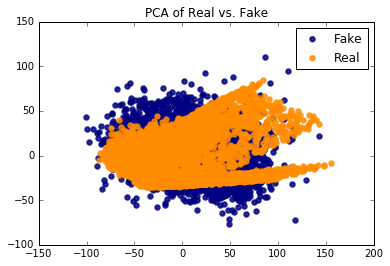

In [305]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_pca = np.concatenate((gen_X_train, X_train))
print(X_pca.shape)

y = np.array([1] * generate_count + [0] * training_size)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')

print(pca.explained_variance_ratio_)

(1000, 36)


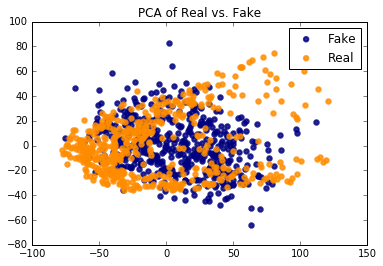

In [306]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plot_count = 500
X_pca = np.concatenate((gen_X_train[:plot_count], X_train[:plot_count]))
print(X_pca.shape)

y = np.array([1] * plot_count + [0] * plot_count)

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')

# Real vs. Fake

In [298]:
clf =  RandomForestClassifier()

X_comb = np.concatenate((gen_X_train, X_train))
y = np.array([1] * generate_count + [0] * training_size)

print(X_comb.shape, y.shape)
scores = cross_val_score(clf, X_comb, y, cv=5)
print(scores)

from sklearn.neighbors import KNeighborsClassifier
nn_clf = KNeighborsClassifier(n_neighbors=9)

scores = cross_val_score(nn_clf, X_comb, y, cv=5)
print(scores)

((12000, 36), (12000,))
[ 0.99833333  0.9975      0.99791667  0.99583333  0.9975    ]
[ 0.97166667  0.96666667  0.96958333  0.97041667  0.97125   ]
